## This is the final deep learning project
## This is an application of facial recognition using a siamese deep neural network

1. Problem statement (0-10)
	* How well is the problem defined?
	* Does the research address a real-life problem?
	* Does the research solve the correct problem?
2. Layout (0-20)
	* Are the document sections structured properly?
	* Is the article well-formatted (in terms of readability)?
3. Code quality (0-20)
	* Is the code well-written? Is the code self-documenting?
	* Is the code organized into functions?
	* Is the code generally well-structured?
4. Previous research (0-10)
	* Have you cited at least two other sources?
	* Does the project contain comparisons between the current and the previous results?
5. Gathering / generating, cleaning, and formatting data (0-10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
6. Testing (0-10)
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?
7. Visualization (0-10)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?
8. Communication (0-10)
	* Does the project tell the story correctly?
	* Does the project serve the audience it was intended for?

# Load libraries

In [1]:
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
import cv2
import os
import random  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

print(tf.__version__)
# from tensorflow import keras

2.11.0


In [3]:
# I will use the functional api for this project


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten



In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Create folder structure

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [3]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# I will use the lfw images as my negatives images 
# Source link: http://vis-www.cs.umass.edu/lfw/ 

#  Transfer the data from the lfw folder to the data/negatives
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

Collect positive and anchor images

what is anchor\
what are positives

In [ ]:
# Library for generating unique image names

import uuid

In [ ]:
uuid.uuid1()

UUID('a19352c9-8c3e-11ed-a5d6-acfdceba6016')

In [ ]:
# CONNECTION TO MY CAMERA
# and gathering of the data

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # make the frame 250/250 pixels
    frame = frame[120:120 + 250,200:200+250,:]

    # colect the anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create an unique name
        image_name = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)

    # collect the positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create an unique name
        image_name = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)

    # Show the image to the screen
    cv2.imshow('Image Collection', frame)

    # wait 1 ms and close if the button 'q' is clicked
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# release the camera
cap.release()
# close the image show frame
cv2.destroyAllWindows()

In [ ]:
# plt.imshow(frame)

Get image directories

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH +'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH +'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data\\anchor\\35384228-8c3f-11ed-81cf-acfdceba6016.jpg'

Preprocessing\
Here I am reading the image,\
then I am decoding/loading the jpeg file.\
I resize the image to be 100x100x3 (this is the recommended size of an image given in the paper[1]).\
I am dividing by 255.0 so that I can get values between 0 and 1.

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img


In [10]:
# img = preprocess(b'data\\anchor\\48b3238c-8c3f-11ed-823c-acfdceba6016.jpg')
# plt.imshow(img)

Create labelled dataset

In [11]:
# (anchor, positive) =>1,1,1,1,1,1
# (anchor, negative) =>0,0,0,0,0,0

positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)



In [12]:
samples = data.as_numpy_iterator()

In [13]:
example = samples.next()

Train and test 

In [14]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [15]:
res = preprocess_twin(*example)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [17]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Here is a quick test

In [18]:
samples = data.as_numpy_iterator()

In [19]:
samp = samples.next()

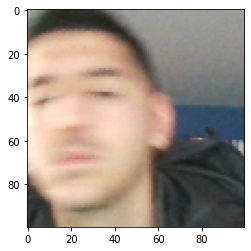

In [20]:
plt.imshow(samp[0])

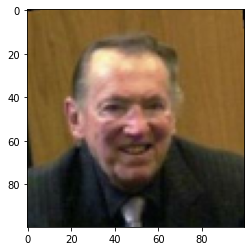

In [21]:
plt.imshow(samp[1])

In [22]:
samp[2]

0.0

In [23]:
# train set
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [25]:
train_samples= train_data.as_numpy_iterator()
train_sample = train_samples.next()


In [26]:
# test set
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data  = test_data.batch(16)
test_data = test_data.prefetch(8)

create embedding layer

In [27]:
def make_embedding():
    # First layer
    inp = Input(shape= (100,100,3), name = 'input_image')
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    maxpool1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    # Second layer
    c2 = Conv2D(128,(7,7), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    # Third layer
    c3 = Conv2D(128,(4,4), activation='relu')(maxpool2)
    maxpool3 = MaxPooling2D(64,(2,2),padding='same')(c3)

    # Final layer
    c4 = Conv2D(256,(4,4), activation='relu')(maxpool3)
    f1 = Flatten()(c4)
    d1= Dense(4096,activation='sigmoid')(f1)


    return Model(inputs =[inp] , outputs=[d1], name='embedding')

In [28]:
embedding = make_embedding()

Here are the shapes of the architecture

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

Distance layer

In [30]:
# Siamese class for measuring the distance using similarity calculation between anchor embedding and validation(pos/neg images) embedding 

class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [31]:
# l1 = L1Dist()

In [32]:
# l1(anchor_embedding, validation_embedding)

create siamese model

In [33]:
input_image = Input(name= 'input_img', shape = (100,100,3))
validation_image = Input(name= 'validation_img', shape = (100,100,3))

In [34]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [35]:
siamese_layer = L1Dist()

In [36]:
distances = siamese_layer(inp_embedding,val_embedding)

In [37]:
def create_siamese_model():
    # anchor image in the network
    input_image = Input(name = 'input_img',shape=(100,100,3))

#   validation image in the network
    validation_image = Input(name = 'validation_img',shape=(100,100,3))

    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image)) 

    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image], outputs = classifier, name = "Siamese_Network" )

In [38]:
siamese_model = create_siamese_model() 

In [39]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

Loss function and set up an optimizer


In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
opt = tf.keras.optimizers.Adam(1e-4)

establish checkpoints

In [42]:
checkpoint_dir = '/.training_checkpoints'
checkpoints_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

custom training step

In [43]:
#  this step is focused on training for one batch

@tf.function
def train_step(batch):
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # get anchor and pos/neg image
        X = batch[:2]
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X,training = True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    #  calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [44]:
from tqdm import tqdm


create a training loop 

In [73]:
#  iterate over every batch in the dataset
def train(data, EPOCHS):
    # loop through the epoch
    for epoch in tqdm(range(1, EPOCHS + 1)):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        # progbar = tf.keras.utils.Progbar(len(data))

        #  loop through each batch
        for idx, batch in enumerate(data):
            # run train step here
            train_step(batch)
            # progbar.update(idx+1)
        # # save checkpoint
        # if epoch % 10 == 0:
        #     checkpoint.save(file_prefix=checkpoints_prefix)

train the model

use tfenv1

In [74]:
EPOCHS = 50

In [75]:
train(train_data,EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]


 Epoch 1/50


  2%|▏         | 1/50 [10:38<8:41:38, 638.75s/it]


 Epoch 2/50


  4%|▍         | 2/50 [21:15<8:29:49, 637.29s/it]


 Epoch 3/50


  6%|▌         | 3/50 [31:32<8:11:59, 628.06s/it]


 Epoch 4/50


  8%|▊         | 4/50 [42:09<8:04:17, 631.69s/it]


 Epoch 5/50


 10%|█         | 5/50 [52:41<7:53:50, 631.79s/it]


 Epoch 6/50


 12%|█▏        | 6/50 [1:03:05<7:41:23, 629.16s/it]


 Epoch 7/50


 14%|█▍        | 7/50 [1:14:04<7:37:54, 638.93s/it]


 Epoch 8/50


 16%|█▌        | 8/50 [1:24:22<7:22:30, 632.15s/it]


 Epoch 9/50


 18%|█▊        | 9/50 [1:34:51<7:11:21, 631.27s/it]


 Epoch 10/50


 20%|██        | 10/50 [1:45:11<6:58:29, 627.73s/it]


 Epoch 11/50


 22%|██▏       | 11/50 [1:55:37<6:47:47, 627.37s/it]


 Epoch 12/50


 24%|██▍       | 12/50 [2:06:09<6:38:09, 628.67s/it]


 Epoch 13/50


 26%|██▌       | 13/50 [2:16:37<6:27:35, 628.52s/it]


 Epoch 14/50


 28%|██▊       | 14/50 [2:27:21<6:19:56, 633.25s/it]


 Epoch 15/50


 30%|███       | 15/50 [2:37:45<6:07:42, 630.36s/it]


 Epoch 16/50


 32%|███▏      | 16/50 [2:48:13<5:56:48, 629.66s/it]


 Epoch 17/50


 34%|███▍      | 17/50 [2:58:39<5:45:47, 628.70s/it]


 Epoch 18/50


 36%|███▌      | 18/50 [3:09:09<5:35:30, 629.07s/it]


 Epoch 19/50


 38%|███▊      | 19/50 [3:19:40<5:25:15, 629.55s/it]


 Epoch 20/50


 40%|████      | 20/50 [3:30:00<5:13:17, 626.58s/it]


 Epoch 21/50


 42%|████▏     | 21/50 [3:40:22<5:02:16, 625.38s/it]


 Epoch 22/50


 44%|████▍     | 22/50 [3:50:28<4:49:05, 619.48s/it]


 Epoch 23/50


 46%|████▌     | 23/50 [4:00:53<4:39:31, 621.17s/it]


 Epoch 24/50


 48%|████▊     | 24/50 [4:11:25<4:30:31, 624.29s/it]


 Epoch 25/50


 50%|█████     | 25/50 [4:21:51<4:20:21, 624.87s/it]


 Epoch 26/50


 52%|█████▏    | 26/50 [4:32:19<4:10:20, 625.86s/it]


 Epoch 27/50


 54%|█████▍    | 27/50 [4:42:48<4:00:18, 626.87s/it]


 Epoch 28/50


 56%|█████▌    | 28/50 [4:53:01<3:48:17, 622.60s/it]


 Epoch 29/50


 58%|█████▊    | 29/50 [5:03:30<3:38:36, 624.60s/it]


 Epoch 30/50


 60%|██████    | 30/50 [5:14:11<3:29:50, 629.51s/it]


 Epoch 31/50


 62%|██████▏   | 31/50 [5:25:07<3:21:49, 637.33s/it]


 Epoch 32/50


 64%|██████▍   | 32/50 [5:35:48<3:11:34, 638.59s/it]


 Epoch 33/50


 66%|██████▌   | 33/50 [5:46:49<3:02:48, 645.19s/it]


 Epoch 34/50


 68%|██████▊   | 34/50 [5:57:34<2:52:05, 645.33s/it]


 Epoch 35/50


 70%|███████   | 35/50 [6:08:13<2:40:48, 643.23s/it]


 Epoch 36/50


 72%|███████▏  | 36/50 [6:18:47<2:29:27, 640.57s/it]


 Epoch 37/50


 74%|███████▍  | 37/50 [6:29:28<2:18:48, 640.66s/it]


 Epoch 38/50


 76%|███████▌  | 38/50 [6:39:40<2:06:25, 632.16s/it]


 Epoch 39/50


 78%|███████▊  | 39/50 [6:50:02<1:55:20, 629.12s/it]


 Epoch 40/50


 80%|████████  | 40/50 [7:00:13<1:43:55, 623.52s/it]


 Epoch 41/50


 82%|████████▏ | 41/50 [7:10:16<1:32:35, 617.30s/it]


 Epoch 42/50


 84%|████████▍ | 42/50 [7:20:54<1:23:08, 623.60s/it]


 Epoch 43/50


 86%|████████▌ | 43/50 [7:31:20<1:12:51, 624.46s/it]


 Epoch 44/50


 88%|████████▊ | 44/50 [7:41:45<1:02:26, 624.37s/it]


 Epoch 45/50


 90%|█████████ | 45/50 [7:51:52<51:36, 619.38s/it]  


 Epoch 46/50


 92%|█████████▏| 46/50 [8:02:02<41:05, 616.40s/it]


 Epoch 47/50


 94%|█████████▍| 47/50 [8:12:20<30:51, 617.07s/it]


 Epoch 48/50


 96%|█████████▌| 48/50 [8:22:40<20:35, 617.91s/it]


 Epoch 49/50


 98%|█████████▊| 49/50 [8:32:50<10:15, 615.48s/it]


 Epoch 50/50


100%|██████████| 50/50 [8:43:00<00:00, 627.62s/it]


evaluate model

In [76]:
from tensorflow.keras.metrics import Precision, Recall
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [77]:
# make some predictions 

y_hat =siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[1.00000000e+00],
       [1.00000000e+00],
       [6.43483045e-10],
       [1.00000000e+00],
       [3.22704446e-10],
       [9.99992490e-01],
       [9.99705136e-01],
       [1.00000000e+00],
       [9.99551237e-01],
       [9.99006808e-01],
       [4.61937211e-10],
       [9.99987841e-01],
       [1.57336455e-08],
       [1.15559494e-07],
       [1.96372467e-11],
       [2.42838816e-08]], dtype=float32)

In [78]:
# post processing the results

[1 if prediction >0.5 else 0 for prediction in y_hat]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]

In [79]:
y_true

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [81]:
# create a recall object
m = Recall()

# calculating the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0

In [82]:
# create a recall object
m = Precision()

# calculating the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0